### Step 0 - Generate data.csv from get_data.py

```bash
$ python get_data.py
```

In [1]:

# Import the libraries
import os

# Data
import pandas as pd
import numpy as np
import yaml
import math

# Plotting
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import manifold
from keras.utils.vis_utils import plot_model

# Preprocessing
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

from sklearn.model_selection import train_test_split

# Word Embedding
import gensim
import gensim.downloader as gensim_api

# Neural network
from tensorflow.keras import models, layers, preprocessing as kprocessing
from sklearn import metrics as sk_metrics

2022-04-21 14:48:48.691538: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 14:48:48.691560: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package stopwords to /home/juan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/juan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/juan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Folder to load config file
CONFIG_PATH = "./"

# Function to load yaml configuration file
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)
    return config

config = load_config("config.yaml")

### Step 1 - Get the data and preprocess it

In [3]:
# Import data.csv
data = pd.read_csv('data.csv')

# Display only certains columns to have better display
# (missing columns: Nb_Parents, Nb_Children, Nb_Parents_Children_Known, Has_Definition)
data.loc[:,['Label', 'Source', 'Definition', 'TUI', 'GUI']].head()

,Label,Source,Definition,TUI,GUI
0,synthetic 11-hydroxycorticosteroids,AOD,NaN,T109,CHEM
1,synthetic 11-hydroxycorticosteroids,AOD,NaN,T121,CHEM
2,17-Hydroxysteroid Dehydrogenases,AOD,A class of enzymes that catalyzes the oxidatio...,T116,CHEM
3,17-Hydroxysteroid Dehydrogenases,AOD,A class of enzymes that catalyzes the oxidatio...,T126,CHEM
4,mesna,ATC,A sulfhydryl compound used to prevent urotheli...,T109,CHEM


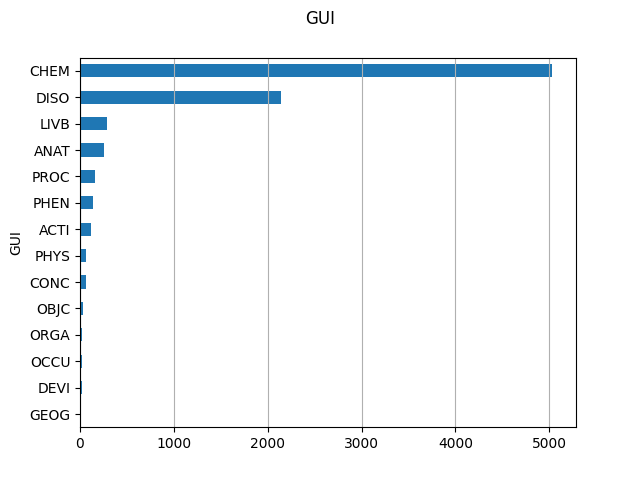

In [4]:
# Plotting the univariate distribution of the data

fig, ax = plt.subplots()
column = config["y_classificaton_column"]
fig.suptitle(column, fontsize=12)
data[column].reset_index().groupby(column).count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

The graph shows that there are differences of distributions between the GUIs

Let's see what looks like **Nb_Parents**, **Nb_Children**, **Nb_Parents_Children_Known** and **Has_Definition** as features !

In [5]:
display(data.loc[:,['Nb_Parents', 'Nb_Children', 'Nb_Parents_Children_Known', 'Has_Definition']].head())

,Nb_Parents,Nb_Children,Nb_Parents_Children_Known,Has_Definition
0,8.0,0.0,1,0
1,8.0,0.0,1,0
2,6.0,1.0,1,1
3,6.0,1.0,1,1
4,5.0,0.0,1,1


Time to preprocess the number of ancestors and descendants

In [6]:
# Prepare the nb_parents and nb_children to be used in the model
mean_all_parents = data['Nb_Parents'].mean()
mean_all_children = data['Nb_Children'].mean()
print("Mean of parents", mean_all_parents)
print("Mean of children", mean_all_children)
data.loc[data['Nb_Parents'].isnull(), 'Nb_Parents'] = mean_all_parents
data.loc[data['Nb_Children'].isnull(), 'Nb_Children'] = mean_all_children

# Normalize the data
data['Nb_Parents'] = (data['Nb_Parents'] - data['Nb_Parents'].min()) / (data['Nb_Parents'].max() - data['Nb_Parents'].min())
data['Nb_Children'] = (data['Nb_Children'] - data['Nb_Children'].min()) / (data['Nb_Children'].max() - data['Nb_Children'].min())

print("\nAfter")
display(data.loc[:,['Nb_Parents', 'Nb_Children', 'Nb_Parents_Children_Known', 'Has_Definition']].head())

Mean of parents 7.9111640571817565
Mean of children 4.185159972770593

After


,Nb_Parents,Nb_Children,Nb_Parents_Children_Known,Has_Definition
0,0.094595,0.00,1,0
1,0.094595,0.00,1,0
2,0.067568,0.01,1,1
3,0.067568,0.01,1,1
4,0.054054,0.00,1,1


Time to preprocess the corpus:

In [7]:
# Picture of the difference between stemming and lemmitization: https://miro.medium.com/max/1400/1*ES5bt7IoInIq2YioQp2zcQ.png

# TODO Upgrade preprocessing -> special for biomedical data

def utils_preprocessing_corpus(text, stopwords=None, stemming=False, lemmitization=False):
    """This function prepare the corpus for the model.
    It can remove stopwords, lemmatize or stemming.

    Args:
        text (str): corpus to be processed
        stopwords (List[str], optional): stopwords to remove. Defaults to None.
        stemming (bool, optional): process stemming. Defaults to False.
        lemmitization (bool, optional): process lemmitization. Defaults to False.
    """
    # Check if the text is NaN
    if text != text:
        return ""
    # Convert text to lowercase
    text = text.lower()
    # Remove links
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Split every word
    text = text.split()
    # Remove stopwords
    if stopwords:
        text = [word for word in text if word not in stopwords]
    # Lemmatisation (convert the word into root word)
    if lemmitization == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        text = [lem.lemmatize(word) for word in text]
    # Stemming (remove -ing, -ly, ...)
    if stemming == True:
        ps = nltk.stem.porter.PorterStemmer()
        text = [ps.stem(word) for word in text]
    # Join the list of words
    text = " ".join(text)
    return text

stopwords = nltk.corpus.stopwords.words("english")
data.loc[:,"Clean_Definition"] = data.loc[:,"Definition"].apply(utils_preprocessing_corpus, args=(stopwords, config["stemming"], config["lemmitization"]))
# Concatenate Label and Clean_Definition in corpus
data.loc[:,"Clean_Definition"] = data.loc[:,"Label"] + " " + data.loc[:,"Clean_Definition"]

# Show 10 random rows
pd.set_option('display.max_colwidth', 80)
data.loc[:,['Definition', 'Clean_Definition']].sample(10)

,Definition,Clean_Definition
6672,NaN,Acute pharyngitis
6959,NaN,Adiposis Dolorosa
2917,NaN,Traffic accidents
541,A synthetic precursor of norepinephrine that is used in the treatment of PAR...,droxidopa synthetic precursor norepinephrine used treatment parkinsonian dis...
4764,NaN,Acid Phosphatase
7491,NaN,adenosine
4705,NaN,Renal tubular acidosis
4999,NaN,Acquired Immunodeficiency Syndrome
8136,Adjuvants are mostly pharmacological agents of drug or biological origin use...,Immunologic Adjuvants adjuvant mostly pharmacological agent drug biological ...
6347,NaN,Adenine Phosphoribosyltransferase


In [8]:
# Split dataset 70/30
df_train, df_test = train_test_split(data, test_size=0.3)

# Get values
column = config["y_classificaton_column"]
y_train = df_train[column].values
y_test = df_test[column].values

Seting up X_train_attributes and X_test_attributes with **Nb_Parents**, **Nb_Children**, **Nb_Parents_Children_Known** and **Has_Definition** as features

In [9]:
X_train_attributes = df_train.loc[:,['Nb_Parents', 'Nb_Children', 'Nb_Parents_Children_Known', 'Has_Definition']].values
X_test_attributes = df_test.loc[:,['Nb_Parents', 'Nb_Children', 'Nb_Parents_Children_Known', 'Has_Definition']].values

Let's tokenize the corpus and train a word2vec model with the training set.

In [10]:
corpus = df_train["Clean_Definition"].values

# Create list of lists of Unigrams (eg. ['I', 'am', 'a', 'student', '.'])
def create_list_unigrams(corpus):
    lst_corpus = []
    for string in corpus:
       lst_words = string.split()
       lst_grams = [" ".join(lst_words[i:i+1]) 
                   for i in range(0, len(lst_words), 1)]
       if len(lst_grams) == 0:
          lst_grams = [""]
       lst_corpus.append(lst_grams)
    return lst_corpus

lst_corpus = create_list_unigrams(corpus)

# Detect Bigrams (eg. ['I am', 'a student', '.'])
bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ", min_count=5, threshold=10)
bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
# Detect Trigrams (eg. ['I am a', 'student.'])
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ", min_count=5, threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

## Fit Word2Vec
nlp = gensim.models.word2vec.Word2Vec(lst_corpus,
   vector_size=config["vector_size"], window=config["window"], min_count=1, sg=1, epochs=config["w2v_epochs"])
print("The model has been trained on {} words.\n".format(nlp.corpus_total_words))
print("Shape of the word2vec model: ", nlp.wv.vectors.shape)
print("It means that there are {} words in the model.".format(nlp.wv.vectors.shape[0]))
print("And each word has {} dimensions' vector.\n".format(nlp.wv.vectors.shape[1]))

word = "amine"
try:
   print("The most similar words to '{}' are:".format(word), nlp.wv.most_similar(word))
except KeyError:
   print("The word '{}' is not in the vocabulary".format(word))

The model has been trained on 46882 words.

Shape of the word2vec model:  (4386, 300)
It means that there are 4386 words in the model.
And each word has 300 dimensions' vector.

The most similar words to 'amine' are: [('2-Hydroxyphenethylamine', 0.8207166194915771), ('simple', 0.8095570802688599), ('nucleobase', 0.7686519026756287), ('vasoconstricting', 0.7616822719573975), ('mutagenicity', 0.7610324025154114), ('carcinogenicity', 0.7490798830986023), ('pressurereducing', 0.7485461235046387), ('heated', 0.7373524308204651), ('bronchodilating', 0.7310711741447449), ('sulfoxyfluorenylacetamide', 0.7244910001754761)]


### Even if there are 300 dimensions, we can try to reduce it to 3 thanks to PCA. This will allow us to visualize the words in 3D.

/home/juan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/juan/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


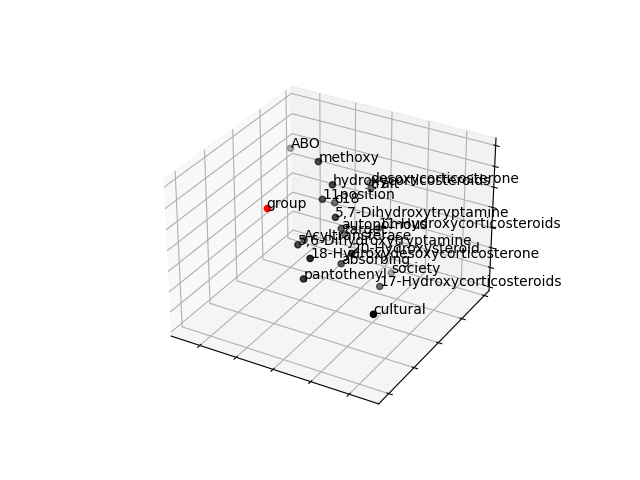

In [11]:
word = "group"

try:
    # Word Embedding
    tot_words = [word] + [tupla[0] for tupla in nlp.wv.most_similar(word, topn=20)]
    X = nlp.wv[tot_words]

    # PCA to reduce dimensionality from 300 to 3
    pca = manifold.TSNE(perplexity=40, n_components=3, init="pca")
    X = pca.fit_transform(X)

    # Create dtf
    df = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    df["input"] = 0
    df.at["group","input"]=1

    # Plot 3d
    from mpl_toolkits.mplot3d import Axes3D

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(df[df["input"]==0]["x"], 
               df[df["input"]==0]["y"], 
               df[df["input"]==0]["z"], c="black")
    ax.scatter(df[df["input"]==1]["x"], 
               df[df["input"]==1]["y"], 
               df[df["input"]==1]["z"], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], 
           yticklabels=[], zticklabels=[])
    for label, row in df[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)
    plt.show()
except Exception as e:
    print("Error: " + str(e))


### To include the corpus as features in a Neural Network, we need to:

1- Transform the corpus into padded sequences of words

2- Create Embedding matrix with as index the id's word and as value it vector

3- Set Embedding layer in the Neural Network so that weights every word

<AxesSubplot:>

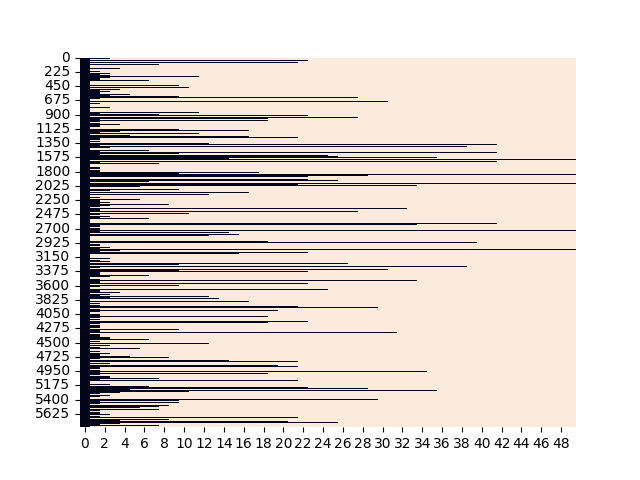

In [12]:
# Tokenize text -> Indexation of each word (eg. {'NaN': 1, 'enzyme': 2, 'amine': 3...})
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', oov_token="NaN",
                                       filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus)
dic_vocabulary = tokenizer.word_index

# Create sequence -> Use index of each word from 'tokenizer' to create sentences (eg. ['amine', 'enzyme'] -> [3, 2])
lst_text2seq= tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence. Each sequence are composed of id or 0 to complete the size of 50
# (eg. [3, 2] -> [3, 2, 0, 0, 0, 0, ..., 0])
X_train_word_embedding = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=config["sequence_length"], padding="post", truncating="post")

# Visualization of the shapes of corpus
fig, ax = plt.subplots()
sns.heatmap(X_train_word_embedding==0, vmin=0, vmax=1, cbar=False)

Let's do the same for the test part.
Why did we separe the train and test data set ?

To be sure the bigrams, trigrams and tokenizer are trained only with the training set and keep the test set unknown of any model.

<AxesSubplot:>

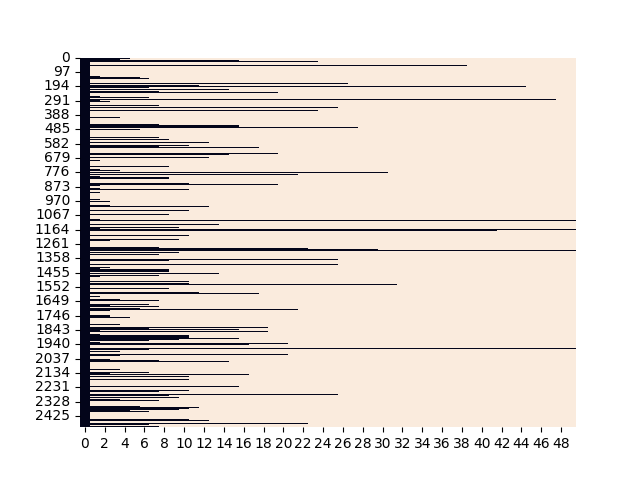

In [13]:
corpus = df_test["Clean_Definition"]

# Create list of lists of Unigrams (eg. ['I', 'am', 'a', 'student', '.'])
lst_corpus = create_list_unigrams(corpus)
    
# Detect common bigrams and trigrams using the fitted detectors
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])

# Text to sequence with the fitted tokenizer
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

# Padding sequence. Each sequence are composed of id or 0 to complete the size of 50
X_test_word_embedding = kprocessing.sequence.pad_sequences(lst_text2seq, maxlen=config["sequence_length"], padding="post", truncating="post")

# Visualization of the shapes of corpus
fig, ax = plt.subplots()
sns.heatmap(X_test_word_embedding==0, vmin=0, vmax=1, cbar=False)

Let's create our Matrix of embedding following this schema

**Embedding Matrix Explanation**:
![Embedding Matrix Explanation](https://miro.medium.com/max/700/1*KvBp0xzRThA7qTXACT4A-g.png)

In [14]:
# Start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, config["vector_size"]))
for word,idx in dic_vocabulary.items():
    # Update the row with vector
    try:
        embeddings[idx] =  nlp[word]
    # If word not in model then skip and the row stays all 0s
    except:
        pass
    
word = "action"
print("dic[word]:", dic_vocabulary[word], "|idx")
print("embeddings[idx]:", embeddings[dic_vocabulary[word]].shape, 
      "|vector")

dic[word]: 25 |idx
embeddings[idx]: (300,) |vector


The Neural Network v1 is built following the [Mauro Di Pietro medium](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794#e0c6)

2022-04-21 14:49:01.328048: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-21 14:49:01.328078: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 14:49:01.328098: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mistea-abricotier): /proc/driver/nvidia/version does not exist
2022-04-21 14:49:01.328285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


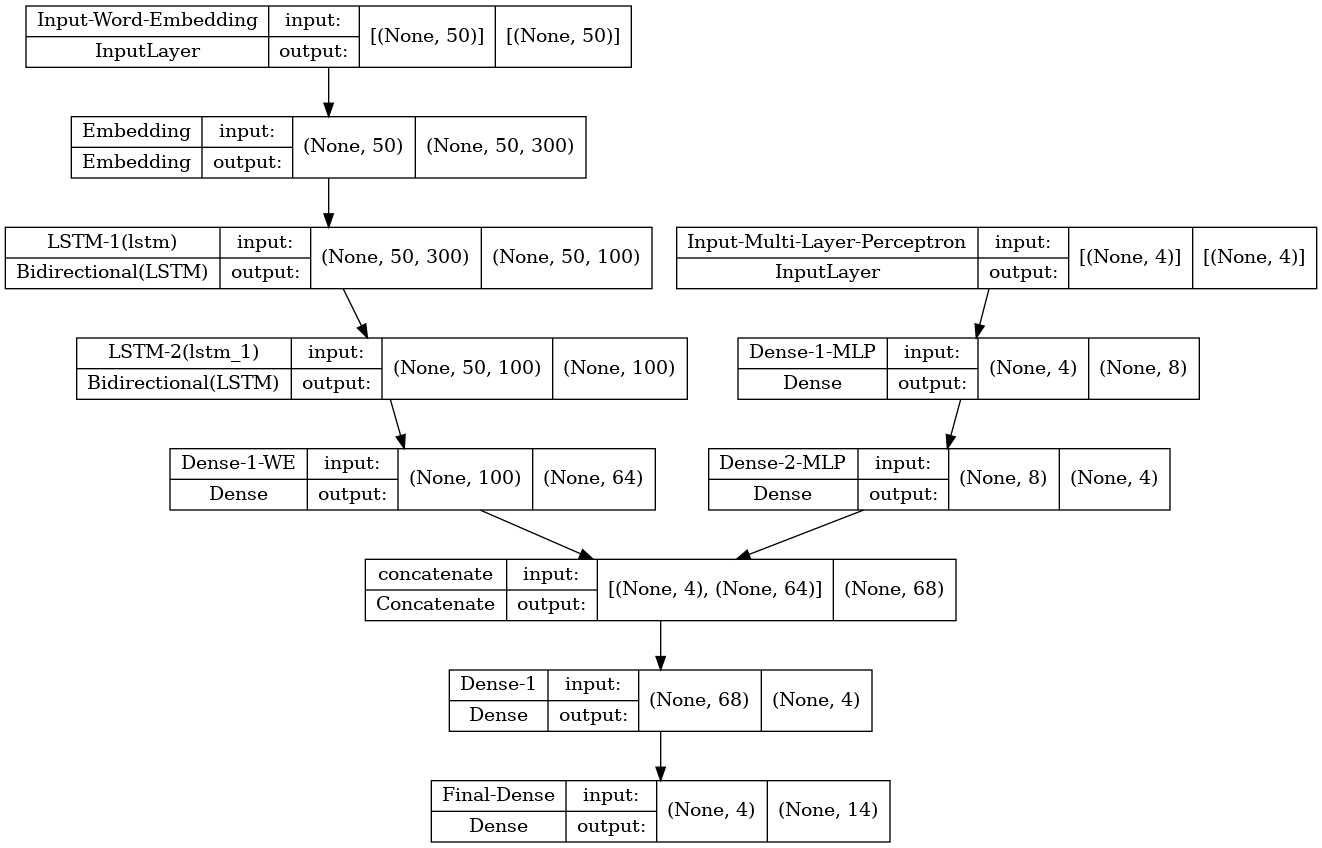

In [15]:
def get_input_layer_and_next_steps(type_model):
    steps = config["neural_network"][type_model]["steps"].copy()
    # Search for the first step with the type "Input"
    first_step = next(step for step in steps if step["type"] == "Input")
    inputs = layers.Input(shape=first_step["input_shape"], name=first_step["name"])
    # Remove first step from the list
    steps.remove(first_step)
    return inputs, steps

def create_model(type_model, inputs=None):
    inputs, steps = get_input_layer_and_next_steps(type_model)

    x = inputs
    for i in steps:
        if i["type"] == "Embedding":
            x = layers.Embedding(input_dim=embeddings.shape[0],
                                 output_dim=embeddings.shape[1],
                                 weights=[embeddings],
                                 trainable=i["trainable"],
                                 name=i["name"])(x)
        elif i["type"] == "LSTM":
            x = layers.Bidirectional(layers.LSTM(
                units=i["units"], return_sequences=i["return_sequences"],
                dropout=i["dropout"]), name=i["name"])(x)
        elif i["type"] == "Dense":
            x = layers.Dense(units=i["units"], activation=i["activation"],
                             name=i["name"])(x)
    
    model = models.Model(inputs, x)
    return model

def create_word_embedding():
    return create_model("word_embedding")

def create_multi_layer_perception():
    return create_model("multi_layer_perception")

def concatenate_neural_network(word_embedding, mlp):
    x = layers.concatenate([mlp.output, word_embedding.output])
    
    steps = config["neural_network"]["concatenate"]["steps"].copy()
    for i in steps:
        if i["type"] == "Dense":
            x = layers.Dense(units=i["units"], activation=i["activation"],
                                         name=i["name"])(x)
            
    # Final layer
    final_activation = config["neural_network"]["out"]["activation"]
    name = config["neural_network"]["out"]["name"]
    y_out = layers.Dense(units=data[config["y_classificaton_column"]].nunique(), activation=final_activation, name=name)(x)
    
    return y_out
    

word_embedding = create_word_embedding()
mlp = create_multi_layer_perception()
y_out = concatenate_neural_network(word_embedding, mlp)
    
optimize = config["neural_network"]["optimizer"]
metrics = config["neural_network"]["metrics"]
loss = config["neural_network"]["loss"]
model_mixed_data = models.Model(inputs=[word_embedding.input, mlp.input], outputs=y_out)
model_mixed_data.compile(loss=loss, optimizer=optimize["name"], metrics=metrics)

# You need to install graphviz (see instructions at https://graphviz.gitlab.io/download/)
plot_model(model_mixed_data, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Let's train the model

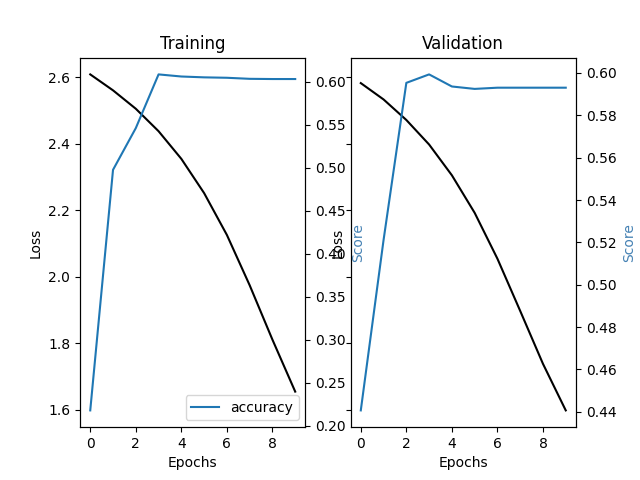

In [16]:
# Encode y_train
dic_y_mapping = {n:label for n,label in 
                 enumerate(np.unique(y_train))}
inverse_dic = {v:k for k,v in dic_y_mapping.items()}
y_train = np.array([inverse_dic[y] for y in y_train])

# Train
# training = model.fit(x=X_train, y=y_train, batch_size=256, 
              #       epochs=10, shuffle=True, verbose=0, 
               #      validation_split=config["test_size"])
training = model_mixed_data.fit(x=[X_train_word_embedding, X_train_attributes], y=y_train, batch_size=256, 
                     epochs=10, shuffle=True, verbose=0, 
                     validation_split=config["test_size"])

# Plot loss and accuracy
metrics = [k for k in training.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True)
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(training.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(training.history[metric], label=metric)
ax11.set_ylabel("Score", color='steelblue')
ax11.legend()
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(training.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
     ax22.plot(training.history['val_'+metric], label=metric)
ax22.set_ylabel("Score", color="steelblue")
plt.show()

Now we need to test the model with the **test set** !

In [17]:
# Test
# predicted_prob = model.predict(X_test)
predicted_prob = model_mixed_data.predict([X_test_word_embedding, X_test_attributes])
predicted = [dic_y_mapping[np.argmax(pred)] for pred in predicted_prob]
print(predicted)


['CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM', 'CHEM',

Visualization of the results:

Accuracy: 0.61
Detail:
              precision    recall  f1-score   support

        ACTI       0.00      0.00      0.00        39
        ANAT       0.00      0.00      0.00        81
        CHEM       0.61      1.00      0.76      1530
        CONC       0.00      0.00      0.00        19
        DEVI       0.00      0.00      0.00         8
        DISO       0.00      0.00      0.00       645
        LIVB       0.00      0.00      0.00        76
        OBJC       0.00      0.00      0.00         7
        OCCU       0.00      0.00      0.00         4
        ORGA       0.00      0.00      0.00         8
        PHEN       0.00      0.00      0.00        38
        PHYS       0.00      0.00      0.00        14
        PROC       0.00      0.00      0.00        33

    accuracy                           0.61      2502
   macro avg       0.05      0.08      0.06      2502
weighted avg       0.37      0.61      0.46      2502



/home/juan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


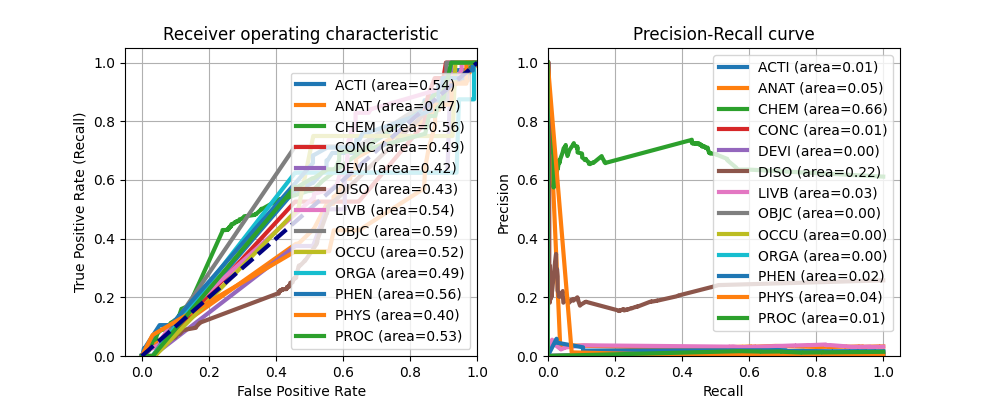

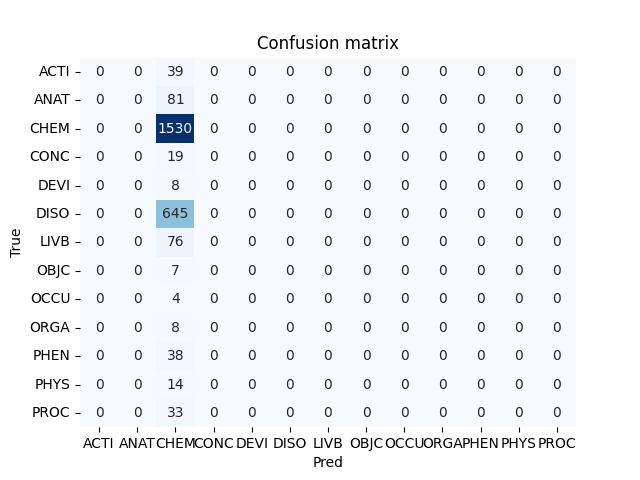

In [18]:
def evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(15,5)):
    classes = np.unique(y_test)
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    accuracy = sk_metrics.accuracy_score(y_test, predicted)
    print("Accuracy:",  round(accuracy,2))
    print("Detail:")
    print(sk_metrics.classification_report(y_test, predicted))
    
    ## Plot confusion matrix
    cm = sk_metrics.confusion_matrix(y_test, predicted)
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    ## Plot roc
    for i in range(len(classes)):
        fpr, tpr, thresholds = sk_metrics.roc_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[0].plot(fpr, tpr, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], sk_metrics.auc(fpr, tpr)))
    ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
    ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], xlabel='False Positive Rate', 
              ylabel="True Positive Rate (Recall)", title="Receiver operating characteristic")
    ax[0].legend(loc="lower right")
    ax[0].grid(True)
    
    ## Plot precision-recall curve
    for i in range(len(classes)):
        precision, recall, thresholds = sk_metrics.precision_recall_curve(y_test_array[:,i], predicted_prob[:,i])
        ax[1].plot(recall, precision, lw=3, label='{0} (area={1:0.2f})'.format(classes[i], sk_metrics.auc(recall, precision)))
    ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', ylabel="Precision", title="Precision-Recall curve")
    ax[1].legend(loc="best")
    ax[1].grid(True)
    plt.show()
    
evaluate_multi_classif(y_test, predicted, predicted_prob, figsize=(10,4))